In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy import stats
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
from scipy.stats import ks_2samp
from scipy.stats import kruskal
import seaborn as sns
from scipy.stats import levene
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix,
    r2_score,
    roc_curve,
    auc,
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score)
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate


In [ ]:
# Let's load in the data and title each column appropriately given what each column represents from the specsheet
num_cols = [
    "average_rating",
    "average_difficulty",
    "num_ratings",
    "pepper",
    "would_take_again",
    "num_online_ratings",
    "male",
    "female",
]

df_numerical = pd.read_csv("rmpCapstoneNum.csv", header=None, names=num_cols)

qual_cols = ["field", "university", "state"]

df_qual = pd.read_csv("rmpCapstoneQual.csv", header=None, names=qual_cols)

tag_cols = [
    "tag_tough_grader",
    "tag_good_feedback",
    "tag_respected",
    "tag_lots_to_read",
    "tag_participation_matters",
    "tag_dont_skip_or_no_pass",
    "tag_lots_of_homework",
    "tag_inspirational",
    "tag_pop_quizzes",
    "tag_accessible",
    "tag_so_many_papers",
    "tag_clear_grading",
    "tag_hilarious",
    "tag_test_heavy",
    "tag_graded_by_few_things",
    "tag_amazing_lectures",
    "tag_caring",
    "tag_extra_credit",
    "tag_group_projects",
    "tag_lecture_heavy",
]

df_tags = pd.read_csv("rmpCapstoneTags.csv", header=None, names=tag_cols)

df = pd.concat([df_numerical, df_qual, df_tags], axis=1)

display(df)

,average_rating,average_difficulty,num_ratings,pepper,would_take_again,num_online_ratings,male,female,field,university,...,tag_so_many_papers,tag_clear_grading,tag_hilarious,tag_test_heavy,tag_graded_by_few_things,tag_amazing_lectures,tag_caring,tag_extra_credit,tag_group_projects,tag_lecture_heavy
0,5.0,1.5,2.0,0.0,NaN,0.0,0,1,Criminal Justice,George Mason University,...,0,0,0,0,0,0,0,0,0,1
1,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2,3.2,3.0,4.0,0.0,NaN,0.0,1,0,English,Alabama State University,...,0,0,0,0,0,0,0,0,0,0
3,3.6,3.5,10.0,1.0,NaN,0.0,0,0,English,University of Kentucky,...,0,2,1,0,0,0,0,0,1,0
4,1.0,5.0,1.0,0.0,NaN,0.0,0,0,English,Keiser University,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89888,2.5,2.5,2.0,0.0,NaN,0.0,0,0,Computer Science,Texas Tech University,...,0,0,0,0,0,0,0,0,0,0
89889,4.5,2.0,2.0,0.0,NaN,0.0,1,0,Theater,University of Winnipeg,...,0,1,0,0,0,0,1,0,0,0
89890,5.0,1.7,6.0,1.0,100.0,2.0,1,0,Criminal Justice,Salt Lake Community College,...,0,0,4,0,0,1,0,0,0,0
89891,3.6,1.8,5.0,0.0,NaN,0.0,0,0,French,University of Ottawa,...,0,4,0,0,0,0,2,0,0,3


## **Data Preprocessing**

In [ ]:
# Check basic stats of dataframe to see how to handle professors with very low number of ratings
display(df['num_ratings'].describe())

# Clean dataframe by removing professors that have less than 10 total ratings, which would not be sufficient to analyze
df_clean = df[df['num_ratings'] > 10].copy()

# Let's drop when we cannot decide if a professor's name is strictly male or female (male & female = 1 or male & female = 0)
df_clean = df_clean[~(((df_clean['male'] == 1) & (df_clean['female'] == 1)) | ((df_clean['male'] == 0) & (df_clean['female'] == 0)))]

# Also drop the NaN rows for would_take_again (they likely don't have many reviews anyway)
df_clean = df_clean.dropna(subset=['would_take_again'])

# Let's normalize the tags by dividing by the number of ratings the professor received, so professors with many ratings are not inflated
tag_cols = [col for col in df_clean.columns if col.startswith("tag_")]

for column in tag_cols:
    df_clean[column] = df_clean[column] / df_clean["num_ratings"]

display(df_clean)

,num_ratings
count,70004.000000
mean,5.374721
std,8.136628
min,1.000000
25%,1.000000
50%,3.000000
75%,6.000000
max,393.000000


,average_rating,average_difficulty,num_ratings,pepper,would_take_again,num_online_ratings,male,female,field,university,...,tag_so_many_papers,tag_clear_grading,tag_hilarious,tag_test_heavy,tag_graded_by_few_things,tag_amazing_lectures,tag_caring,tag_extra_credit,tag_group_projects,tag_lecture_heavy
5,3.5,3.3,22.0,0.0,56.0,7.0,1,0,English,Eastern Florida State College,...,0.000000,0.318182,0.136364,0.000000,0.000000,0.000000,0.136364,0.000000,0.045455,0.136364
25,4.3,3.3,16.0,1.0,83.0,0.0,0,1,English,Concordia University,...,0.000000,0.000000,0.062500,0.000000,0.000000,0.125000,0.625000,0.000000,0.000000,0.062500
40,1.8,3.8,15.0,0.0,22.0,1.0,0,1,Psychology,Florida State College at Jacksonville,...,0.000000,0.066667,0.000000,0.133333,0.066667,0.133333,0.066667,0.000000,0.000000,0.000000
42,4.1,3.3,21.0,0.0,67.0,0.0,0,1,English,Texas A&M University at College Station,...,0.047619,0.000000,0.047619,0.000000,0.000000,0.238095,0.047619,0.142857,0.095238,0.095238
46,4.2,1.8,26.0,1.0,57.0,8.0,1,0,History,Pasadena City College,...,0.000000,0.230769,0.192308,0.000000,0.076923,0.423077,0.038462,0.076923,0.000000,0.076923
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89784,2.6,3.9,14.0,0.0,55.0,0.0,1,0,Mathematics,George Mason University,...,0.000000,0.071429,0.000000,0.000000,0.071429,0.071429,0.071429,0.071429,0.000000,0.357143
89801,4.8,2.8,13.0,1.0,100.0,0.0,0,1,Child Development,California State University Dominguez Hills,...,0.000000,0.076923,0.076923,0.000000,0.000000,0.538462,0.384615,0.000000,0.153846,0.000000
89810,3.4,3.4,14.0,0.0,54.0,5.0,1,0,Music,Weber State University,...,0.000000,0.357143,0.285714,0.071429,0.000000,0.214286,0.000000,0.071429,0.000000,0.357143
89855,4.0,1.9,11.0,1.0,60.0,0.0,1,0,Economics,University of Victoria,...,0.000000,0.090909,0.000000,0.000000,0.363636,0.090909,0.090909,0.000000,0.090909,0.181818



Mann-Whitney U test for Average Ratings by Gender: U = 3512290.500, p = 0.0027319692


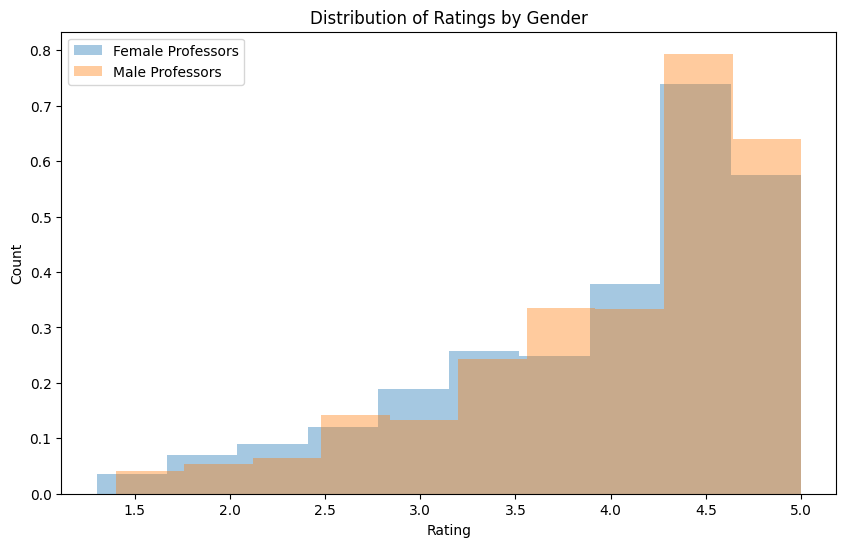

In [ ]:
# Let's test if there is a bias towards male professors (rated higher than female professors)

# Get the female and male professor dataframes
female_ratings = df_clean[df_clean['female'] == 1]['average_rating']
male_ratings = df_clean[df_clean['male'] == 1]['average_rating']

U_test_gender, U_test_p_gender = mannwhitneyu(male_ratings, female_ratings, alternative='greater')

print(f'\nMann-Whitney U test for Average Ratings by Gender: U = {U_test_gender:.3f}, p = {U_test_p_gender:.10f}')

plt.figure(figsize=(10, 6))

plt.hist(female_ratings, bins=10, alpha=0.4, label='Female Professors', density=True)
plt.hist(male_ratings, bins=10, alpha=0.4, label='Male Professors', density=True)
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Ratings by Gender')
plt.legend()
plt.show()

In [ ]:
num_female_professors = df_clean['female'].value_counts().get(1, 0)
num_male_professors = df_clean['male'].value_counts().get(1, 0)

print(f"Number of female professors in df_clean: {num_female_professors}")
print(f"Number of male professors in df_clean: {num_male_professors}")

Number of female professors in df_clean: 2274
Number of male professors in df_clean: 2957



Levene test for Difference in Variance of Ratings by Gender: Levene = 9.685, p = 0.0018681157
Male SD: 0.7997125592136559 Female SD: 0.8473063197944044


/tmp/ipython-input-2485660252.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


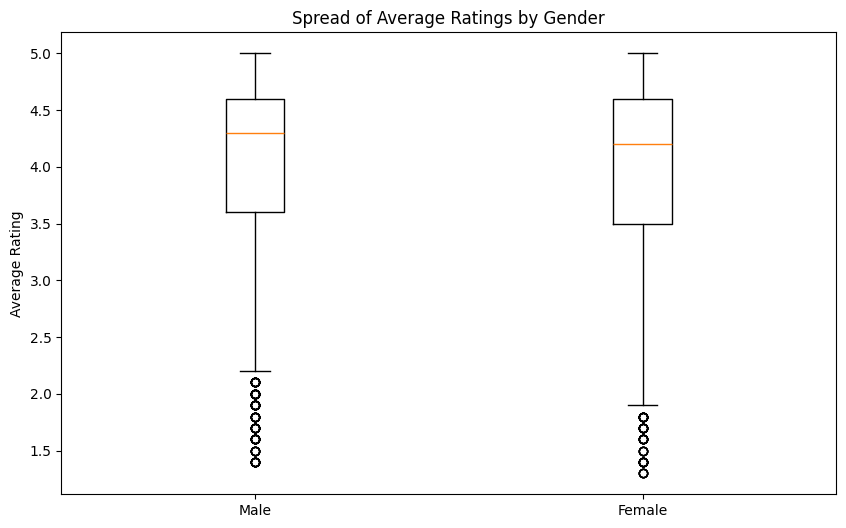

In [ ]:
# Is there a gender difference in the spread (variance/dispersion) of the ratings distribution?

gender_levene_stat, gender_levene_p_val = levene(male_ratings, female_ratings)

print(f'\nLevene test for Difference in Variance of Ratings by Gender: Levene = {gender_levene_stat:.3f}, p = {gender_levene_p_val:.10f}')

male_std = male_ratings.std()
female_std = female_ratings.std()
print("Male SD:", male_std, "Female SD:", female_std)

plt.figure(figsize=(10, 6))

plt.boxplot(
    [male_ratings, female_ratings],
    labels=['Male', 'Female'],
    showfliers=True
)
plt.ylabel('Average Rating')
plt.title('Spread of Average Ratings by Gender')
plt.show()

Bootstrapped 95% CI for Cohen's d of Ratings by Gender: [0.035, 0.145]


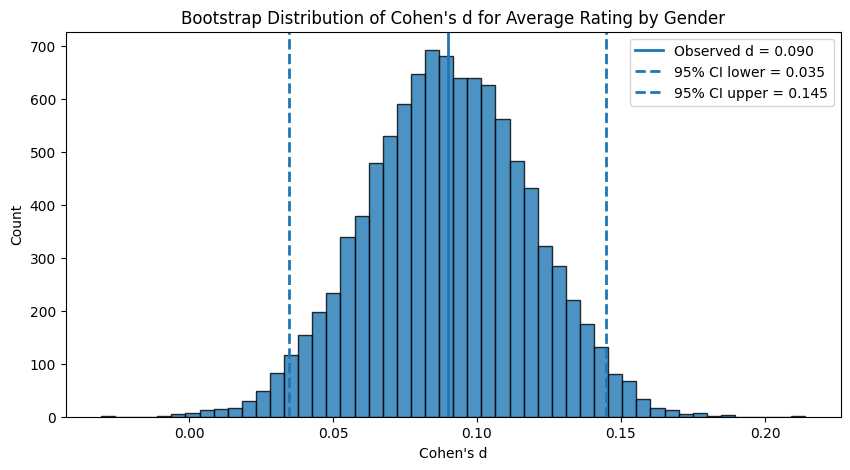

Standard devation ratio: 0.944
Bootstrapped 95% confidence interval for SD ratio: [0.905, 0.984]


In [ ]:
# What is the likely size of both of these effects (gender bias in average rating, gender bias in spread of
# average rating) at 95% Confidence.

# Let's create a function for computing cohen's d using the known formula
def cohen_d(x, y):
    # Pooled SD
    n_x, n_y = len(x), len(y)
    s_x, s_y = x.std(ddof=1), y.std(ddof=1)
    s_pooled = np.sqrt(((n_x-1)*s_x**2 + (n_y-1)*s_y**2)/(n_x+n_y-2))
    return (x.mean() - y.mean()) / s_pooled

# Now we are going to bootstrap cohen's d as the data is not normally distributed. We will set our RNG seed to my N number and create 10,000 resamples
n_boot = 10_000
# My N number
N_number = 13829336
rng = np.random.default_rng(seed=N_number)

boot_d = []
for _ in range(n_boot):
    boot_x = rng.choice(male_ratings, size=len(male_ratings), replace=True)
    boot_y = rng.choice(female_ratings, size=len(female_ratings), replace=True)
    boot_d.append(cohen_d(boot_x, boot_y))

# Use the 95% CI
ci_lower, ci_upper = np.percentile(boot_d, [2.5, 97.5])
print(f"Bootstrapped 95% CI for Cohen's d of Ratings by Gender: [{ci_lower:.3f}, {ci_upper:.3f}]")

boot_d = np.array(boot_d)

# Plotting the bootstrap distribution
d_hat = cohen_d(male_ratings, female_ratings)

plt.figure(figsize=(10, 5))
plt.hist(boot_d, bins=50, edgecolor='black', alpha=0.8)

plt.axvline(d_hat, linewidth=2, label=f"Observed d = {d_hat:.3f}")
plt.axvline(ci_lower, linestyle='--', linewidth=2, label=f"95% CI lower = {ci_lower:.3f}")
plt.axvline(ci_upper, linestyle='--', linewidth=2, label=f"95% CI upper = {ci_upper:.3f}")

plt.title("Bootstrap Distribution of Cohen's d for Average Rating by Gender")
plt.xlabel("Cohen's d")
plt.ylabel("Count")
plt.legend()
plt.show()

# Now let's repeat this for the spread of the average ratings

def sd_ratio(x, y):
    """
    Compute the ratio of the two inputs standard deviations

    return: ratio of x's std over y's std
    """
    return x.std(ddof=1) / y.std(ddof=1)

boot_sd_ratio = []

for _ in range(n_boot):
    boot_x = rng.choice(male_ratings, size=len(male_ratings), replace=True)
    boot_y = rng.choice(female_ratings, size=len(female_ratings), replace=True)
    boot_sd_ratio.append(sd_ratio(boot_x, boot_y))

boot_sd_ratio = np.array(boot_sd_ratio)

# Define the 95% confidence interval
ci_lower_sd, ci_upper_sd = np.percentile(boot_sd_ratio, [2.5, 97.5])

sd_ratio_hat = sd_ratio(male_ratings, female_ratings)

print(f"Standard devation ratio: {sd_ratio_hat:.3f}")
print(f"Bootstrapped 95% confidence interval for SD ratio: [{ci_lower_sd:.3f}, {ci_upper_sd:.3f}]")


,Tag,U_stat,p_value
12,tag_hilarious,4249829.5,2.017275e-63
16,tag_caring,2876025.0,2.541569e-19
2,tag_respected,3758630.5,2.070137e-13
17,tag_extra_credit,2992753.0,8.985230e-13
15,tag_amazing_lectures,3733719.5,3.797753e-12
4,tag_participation_matters,3018860.0,1.847191e-10
14,tag_graded_by_few_things,3634877.5,3.086073e-09
18,tag_group_projects,3105781.5,6.242005e-09
1,tag_good_feedback,3057489.0,1.807318e-08
10,tag_so_many_papers,3150109.0,1.875796e-07


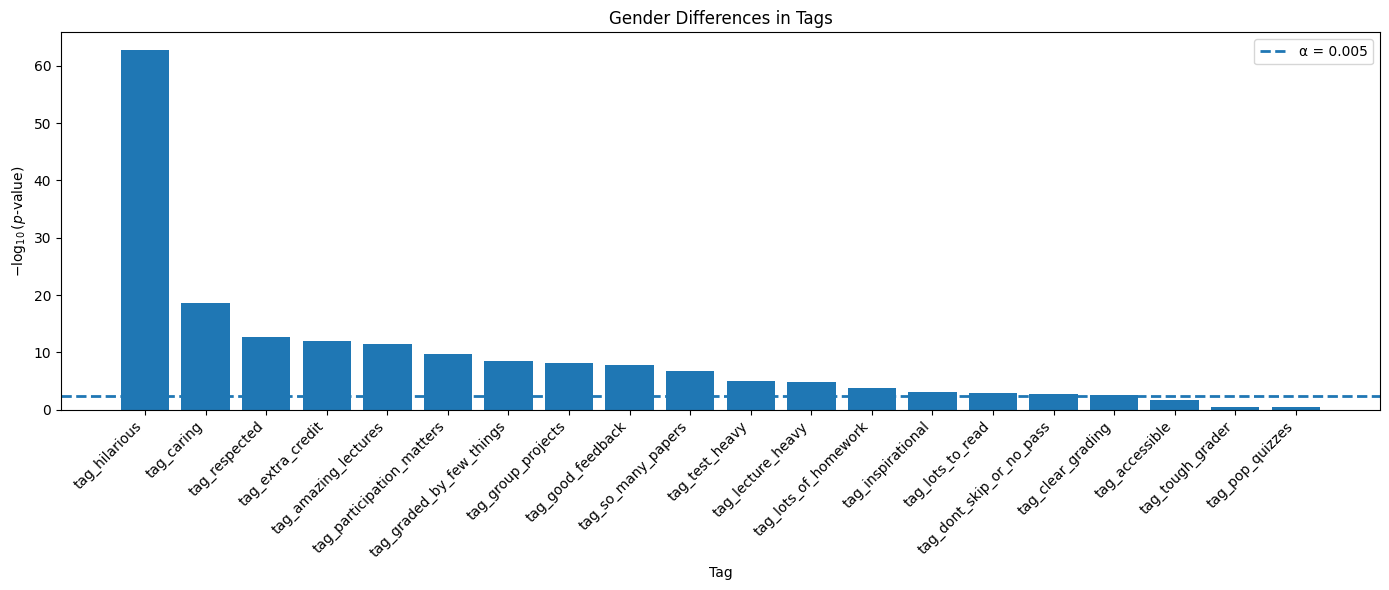

In [ ]:
# Is there a gender difference in the tags awarded by students?

tag_tests = []

# We will loop through each tag of the dataframe and compute a U-test based on gender
for tag in tag_cols:
    male_tag = df_clean[df_clean['male']==1][tag]
    female_tag = df_clean[df_clean['female']==1][tag]

    gender_tag_U_stat, gender_tag_p_val = mannwhitneyu(male_tag, female_tag, alternative='two-sided')
    tag_tests.append({'Tag': tag, 'U_stat': gender_tag_U_stat, 'p_value': gender_tag_p_val})

# Let's make this a pandas df
tag_tests_df = pd.DataFrame(tag_tests)

# Sort the values by lowest p values first
tag_tests_df = tag_tests_df.sort_values('p_value')
display(tag_tests_df)

plot_df = tag_tests_df.copy()
plot_df['neg_log10_p'] = -np.log10(plot_df['p_value'])

alpha = 0.005
threshold = -np.log10(alpha)

plt.figure(figsize=(14, 6))
plt.bar(plot_df['Tag'], plot_df['neg_log10_p'])

# Significance threshold
plt.axhline(threshold, linestyle='--', linewidth=2, label='α = 0.005')

plt.ylabel(r'$-\log_{10}(p\text{-value})$')
plt.xlabel('Tag')
plt.title('Gender Differences in Tags')
plt.legend()

# Rotate tag labels for readability
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()



Mann-Whitney U test for Average Difficulty by Gender: U = 3397192.500, p = 0.5166884768


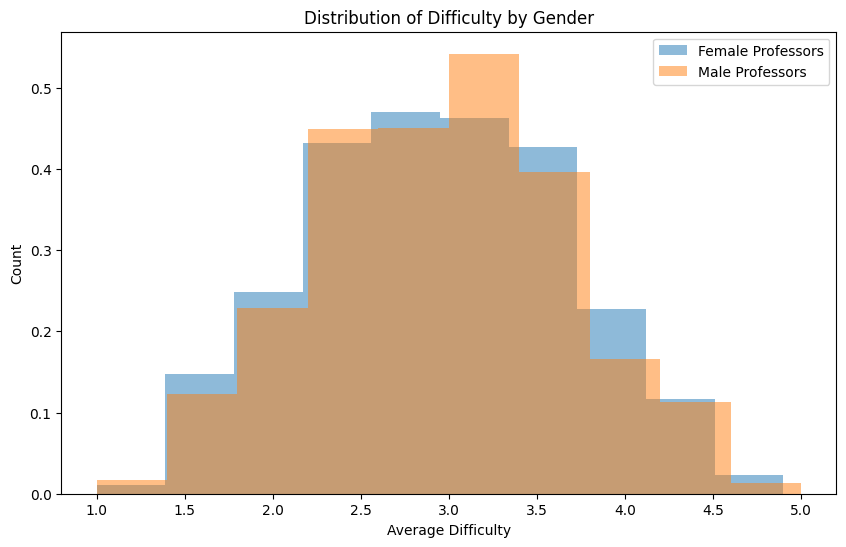

In [ ]:
# Is there a gender difference in terms of average difficulty?

# Get the average difficulty for (explicity) male and female professors
female_difficulty = df_clean[df_clean['female'] == 1]['average_difficulty']
male_difficulty = df_clean[df_clean['male'] == 1]['average_difficulty']

# Do a two-sided U-test based on difficulty by gender
U_test_gender_difficulty, U_test_p_gender_difficulty = mannwhitneyu(male_difficulty, female_difficulty, alternative='two-sided')

print(f'\nMann-Whitney U test for Average Difficulty by Gender: U = {U_test_gender_difficulty:.3f}, p = {U_test_p_gender_difficulty:.10f}')

plt.figure(figsize=(10, 6))

plt.hist(female_difficulty, bins=10, alpha=0.5, label='Female Professors', density=True)
plt.hist(male_difficulty, bins=10, alpha=0.5, label='Male Professors', density=True)
plt.xlabel('Average Difficulty')
plt.ylabel('Count')
plt.title('Distribution of Difficulty by Gender')
plt.legend()
plt.show()

Cohen's d (difficulty): 0.017
95% CI for Cohen's d: [-0.038, 0.072]


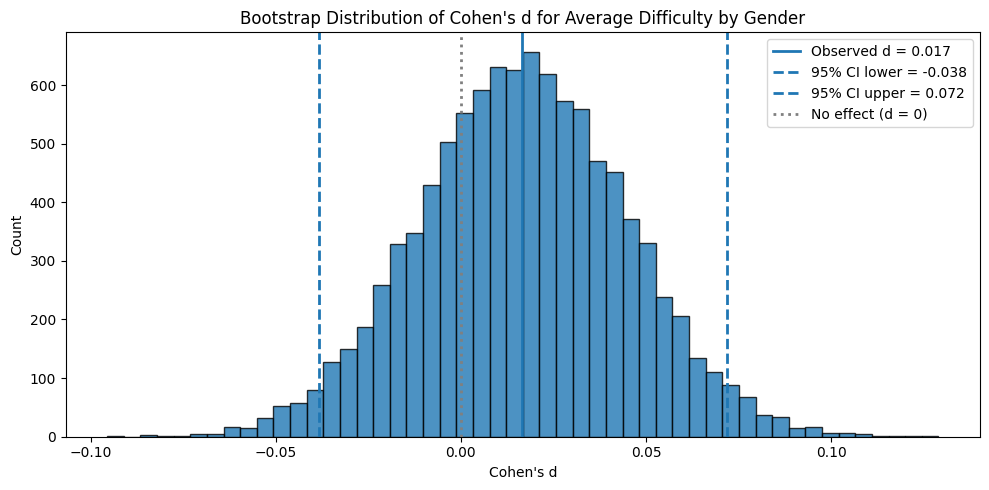

In [ ]:
# Let's quantify the likely size of this effect at 95% confidence.
rng = np.random.default_rng(seed=N_number)

n_boot = 10_000
boot_d = []

for _ in range(n_boot):
    boot_male = rng.choice(male_difficulty, size=len(male_difficulty), replace=True)
    boot_female = rng.choice(female_difficulty, size=len(female_difficulty), replace=True)
    boot_d.append(cohen_d(boot_male, boot_female))

ci_lower, ci_upper = np.percentile(boot_d, [2.5, 97.5])
print(f"Cohen's d (difficulty): {cohen_d(male_difficulty, female_difficulty):.3f}")
print(f"95% CI for Cohen's d: [{ci_lower:.3f}, {ci_upper:.3f}]")

boot_d = np.array(boot_d)

# Observed Cohen's d from the original samples
d_hat = cohen_d(male_difficulty, female_difficulty)

# Plotting the bootstrapped Cohen's d
plt.figure(figsize=(10, 5))
plt.hist(boot_d, bins=50, edgecolor='black', alpha=0.8)

plt.axvline(d_hat, linewidth=2, label=f"Observed d = {d_hat:.3f}")
plt.axvline(ci_lower, linestyle='--', linewidth=2, label=f"95% CI lower = {ci_lower:.3f}")
plt.axvline(ci_upper, linestyle='--', linewidth=2, label=f"95% CI upper = {ci_upper:.3f}")
plt.axvline(0, color='gray', linestyle=':', linewidth=2, label="No effect (d = 0)")

plt.title("Bootstrap Distribution of Cohen's d for Average Difficulty by Gender")
plt.xlabel("Cohen's d")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()

would_take_again      0.879287
average_difficulty   -0.630969
pepper                0.510465
num_ratings           0.045432
male                  0.044531
female               -0.044531
num_online_ratings   -0.001295
dtype: float64

Multicollinearity Analysis:
Found 1 feature pairs with |r| > 0.6

Most correlated feature pairs:
  Feature 1 Feature 2  Correlation
0      male    female         -1.0


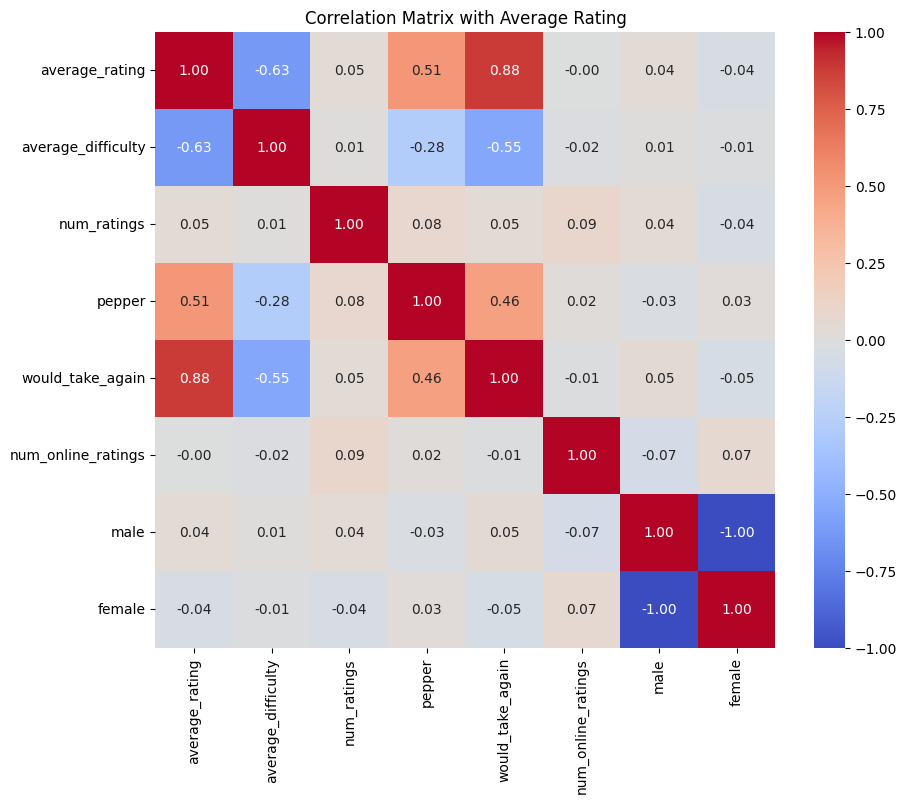

                            OLS Regression Results                            
Dep. Variable:         average_rating   R-squared:                       0.816
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     3865.
Date:                Fri, 19 Dec 2025   Prob (F-statistic):               0.00
Time:                        22:39:41   Log-Likelihood:                -1963.7
No. Observations:                5231   AIC:                             3941.
Df Residuals:                    5224   BIC:                             3987.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              2.6690      0

In [ ]:
# Let's build a regression model predicting average rating from all numerical predictors (the ones in the
# rmpCapstoneNum.csv) file.Which of these factors is most strongly predictive of average rating?

# Let's first look at the correlation matrix with target variable:
target = df_clean['average_rating']

predictors = df_clean[['average_difficulty', 'num_ratings', 'pepper',
                       'would_take_again', 'num_online_ratings', 'male', 'female']]

correlations = predictors.corrwith(target).sort_values(ascending=False, key=abs)
print(correlations)

# Using what we were taught from the lab to check pairwise correlations / multicollinearity (Credit/Reference to Judy Yang and Hamza Alshamy for below loop)
high_correlation_predictors = []
features_correlations = predictors.corr()

for i in range(len(features_correlations.columns)):
    for j in range(i+1, len(features_correlations.columns)):
        if abs(features_correlations.iloc[i, j]) > 0.6:
            high_correlation_predictors.append({
                'Feature 1': features_correlations.columns[i],
                'Feature 2': features_correlations.columns[j],
                'Correlation': features_correlations.iloc[i, j]
            })

print("\nMulticollinearity Analysis:")
print(f"Found {len(high_correlation_predictors)} feature pairs with |r| > 0.6")

if len(high_correlation_predictors) > 0:
    print('\nMost correlated feature pairs:')
    high_corr_df = pd.DataFrame(high_correlation_predictors)
    high_corr_df = high_corr_df.sort_values('Correlation', key=abs, ascending=False)
    print(high_corr_df)
else:
  # If no correlations meet our threshold
  print('No predictors highly correlated')

full_corr = df_clean[['average_rating'] + list(predictors.columns)].corr()

plt.figure(figsize=(10,8))
sns.heatmap(full_corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix with Average Rating")
plt.show()

# Now let's create our linear regression model
target_string = "average_rating"

# These are the predictors we are told to use, removing one of the gender columns as they are perfectly correlated
predictors_strings = ['average_difficulty', 'num_ratings', 'pepper', 'would_take_again', 'num_online_ratings', 'male']

# Define the setup for using the OLS in stats
target_and_predictors = target_string + '~' + "+".join(predictors_strings)

model = smf.ols(target_and_predictors, df_clean).fit()

print(model.summary())

# Get the rows actually used by the model
used_idx = model.model.data.row_labels

y_true = df_clean.loc[used_idx, target_string]
y_pred = model.predict(df_clean.loc[used_idx])

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = model.rsquared

print(f"R²: {r2:.3f}")
print(f"RMSE: {rmse:.3f}")


tag_tough_grader            -0.700516
tag_respected                0.567258
tag_caring                   0.514437
tag_amazing_lectures         0.461516
tag_inspirational            0.446465
tag_good_feedback            0.445128
tag_lecture_heavy           -0.418276
tag_test_heavy              -0.382910
tag_lots_of_homework        -0.375064
tag_hilarious                0.365820
tag_dont_skip_or_no_pass    -0.319937
tag_clear_grading            0.284268
tag_lots_to_read            -0.282043
tag_so_many_papers          -0.231115
tag_graded_by_few_things    -0.212895
tag_accessible               0.165865
tag_extra_credit             0.135469
tag_pop_quizzes             -0.129764
tag_participation_matters    0.092129
tag_group_projects          -0.085675
dtype: float64

Multicollinearity Analysis:
Found 0 feature pairs with |r| > 0.6
No predictors highly correlated


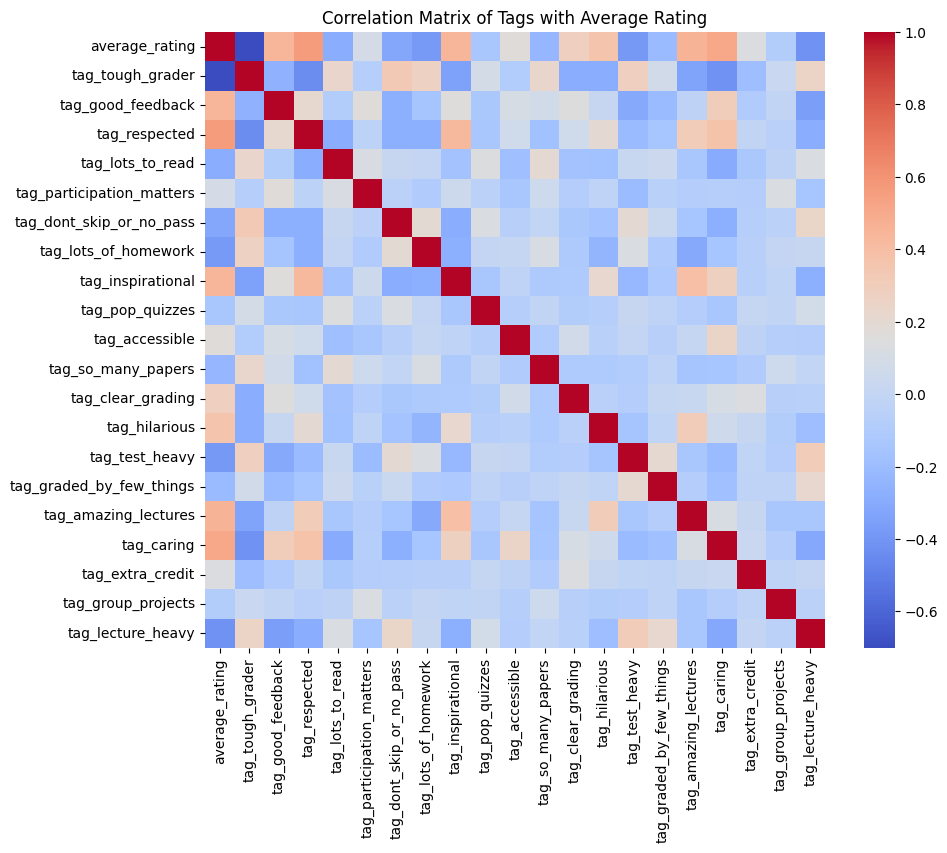

Optimal alpha (λ): 26.3665
Train R²: 0.784
Test R²: 0.754
Test RMSE: 0.397


,Predictor,Coefficient
0,tag_tough_grader,-0.214171
1,tag_good_feedback,0.185690
15,tag_amazing_lectures,0.172194
2,tag_respected,0.148280
16,tag_caring,0.135107
12,tag_hilarious,0.123643
11,tag_clear_grading,0.110071
17,tag_extra_credit,0.076845
4,tag_participation_matters,0.069878
7,tag_inspirational,0.066991


In [ ]:
# Let's build a regression model predicting average ratings from all tags (the ones in the
# rmpCapstoneTags.csv) file. Which of these tags is most strongly predictive of average rating?

# Let's first look at the correlation matrix with target variable:
target = df_clean['average_rating']

predictors = df_clean[tag_cols]

correlations = predictors.corrwith(target).sort_values(ascending=False, key=abs)
print(correlations)

# Using what we were taught from the lab to check pairwise correlations / multicollinearity (Credit/Reference to Judy Yang and Hamza Alshamy for below loop)
high_correlation_predictors = []
features_correlations = predictors.corr()

for i in range(len(features_correlations.columns)):
    for j in range(i+1, len(features_correlations.columns)):
        if abs(features_correlations.iloc[i, j]) > 0.6:
            high_correlation_predictors.append({
                'Feature 1': features_correlations.columns[i],
                'Feature 2': features_correlations.columns[j],
                'Correlation': features_correlations.iloc[i, j]
            })

print("\nMulticollinearity Analysis:")
print(f"Found {len(high_correlation_predictors)} feature pairs with |r| > 0.6")

if len(high_correlation_predictors) > 0:
    print('\nMost correlated feature pairs:')
    high_corr_df = pd.DataFrame(high_correlation_predictors)
    high_corr_df = high_corr_df.sort_values('Correlation', key=abs, ascending=False)
    print(high_corr_df)
else:
  # If no correlations meet our threshold
  print('No predictors highly correlated')

full_corr = df_clean[['average_rating'] + list(predictors.columns)].corr()

plt.figure(figsize=(10,8))
sns.heatmap(full_corr, annot=False, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix of Tags with Average Rating")
plt.show()

# Now let's create our linear regression model using Ridge Regression
X = predictors

y = target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=N_number
)

scaler = StandardScaler()

X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

alphas = np.logspace(-3, 3, 20)

ridge = RidgeCV(alphas=alphas, cv=5)
ridge.fit(X_train_std, y_train)

r2_train = ridge.score(X_train_std, y_train)
r2_test = ridge.score(X_test_std, y_test)

y_pred = ridge.predict(X_test_std)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Optimal alpha (λ): {ridge.alpha_:.4f}")
print(f"Train R²: {r2_train:.3f}")
print(f"Test R²: {r2_test:.3f}")
print(f"Test RMSE: {rmse:.3f}")

coef_df = pd.DataFrame({
    'Predictor': X.columns,
    'Coefficient': ridge.coef_
}).sort_values('Coefficient', key=abs, ascending=False)

display(coef_df)


tag_tough_grader             0.708337
tag_respected               -0.383419
tag_dont_skip_or_no_pass     0.370323
tag_test_heavy               0.369869
tag_caring                  -0.356023
tag_lots_of_homework         0.331448
tag_hilarious               -0.320419
tag_inspirational           -0.306530
tag_clear_grading           -0.306468
tag_lecture_heavy            0.275205
tag_lots_to_read             0.273247
tag_amazing_lectures        -0.241053
tag_good_feedback           -0.239317
tag_extra_credit            -0.213623
tag_so_many_papers           0.160152
tag_pop_quizzes              0.106732
tag_participation_matters   -0.089196
tag_accessible               0.063582
tag_group_projects          -0.033331
tag_graded_by_few_things     0.022295
dtype: float64

Multicollinearity Analysis:
Found 0 feature pairs with |r| > 0.6
No predictors highly correlated


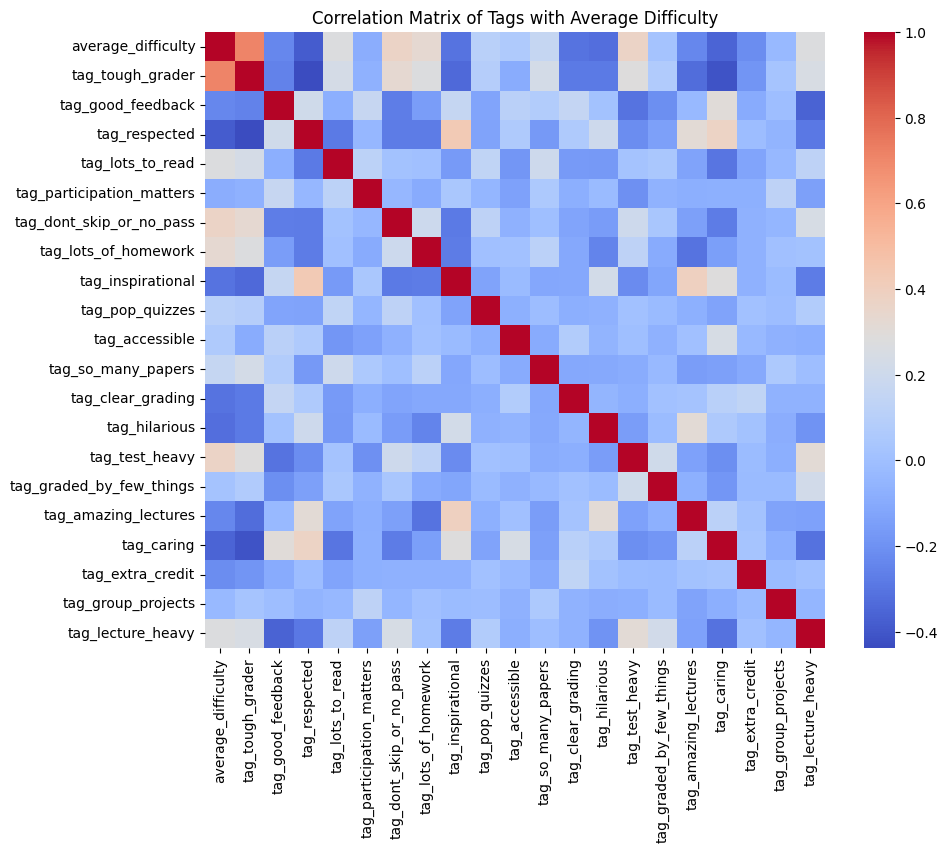

Optimal lambda (alpha): 26.3665
Train R²: 0.632
Test R²: 0.618
Test RMSE: 0.449


,Tag,Coefficient
0,tag_tough_grader,0.361088
13,tag_test_heavy,0.120699
9,tag_accessible,0.109374
11,tag_clear_grading,-0.084445
3,tag_lots_to_read,0.084264
6,tag_lots_of_homework,0.082630
5,tag_dont_skip_or_no_pass,0.077511
12,tag_hilarious,-0.064984
17,tag_extra_credit,-0.053788
14,tag_graded_by_few_things,-0.040780


In [ ]:
# Let's build a regression model predicting average difficulty from all tags (the ones in the
# rmpCapstoneTags.csv) file. Which of these tags is most strongly predictive of average difficulty?

# Let's first look at the correlation matrix with target variable:
target = df_clean['average_difficulty']

predictors = df_clean[tag_cols]

correlations = predictors.corrwith(target).sort_values(ascending=False, key=abs)
print(correlations)

# Using what we were taught from the lab to check pairwise correlations / multicollinearity
high_correlation_predictors = []
features_correlations = predictors.corr()

for i in range(len(features_correlations.columns)):
    for j in range(i+1, len(features_correlations.columns)):
        if abs(features_correlations.iloc[i, j]) > 0.6:
            high_correlation_predictors.append({
                'Feature 1': features_correlations.columns[i],
                'Feature 2': features_correlations.columns[j],
                'Correlation': features_correlations.iloc[i, j]
            })

print("\nMulticollinearity Analysis:")
print(f"Found {len(high_correlation_predictors)} feature pairs with |r| > 0.6")

if len(high_correlation_predictors) > 0:
    print('\nMost correlated feature pairs:')
    high_corr_df = pd.DataFrame(high_correlation_predictors)
    high_corr_df = high_corr_df.sort_values('Correlation', key=abs, ascending=False)
    print(high_corr_df)
else:
  # If no correlations meet our threshold
  print('No predictors highly correlated')

full_corr = df_clean[['average_difficulty'] + list(predictors.columns)].corr()

plt.figure(figsize=(10,8))
sns.heatmap(full_corr, annot=False, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix of Tags with Average Difficulty")
plt.show()

# Now let's create our linear regression model
y = df_clean['average_difficulty']
X = df_clean[tag_cols]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=N_number
)

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

alphas = np.logspace(-3, 3, 20)

ridge = RidgeCV(alphas=alphas, cv=5)
ridge.fit(X_train_std, y_train)

# R2
r2_train = ridge.score(X_train_std, y_train)
r2_test = ridge.score(X_test_std, y_test)

# RMSE
y_pred = ridge.predict(X_test_std)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Optimal lambda (alpha): {ridge.alpha_:.4f}")
print(f"Train R²: {r2_train:.3f}")
print(f"Test R²: {r2_test:.3f}")
print(f"Test RMSE: {rmse:.3f}")

coef_df = pd.DataFrame({
    'Tag': tag_cols,
    'Coefficient': ridge.coef_
}).sort_values('Coefficient', key=abs, ascending=False)

display(coef_df)


In [ ]:
# Count the occurrences of pepper = 1 and pepper = 0
pepper_counts = df_clean['pepper'].value_counts()

print("Count of 'pepper' values (0 = no, 1 = yes):")
display(pepper_counts)

Count of 'pepper' values (0 = no, 1 = yes):


,count
pepper,
1.0,2669
0.0,2562


Suggested threshold (from train): 0.488
Cross-Validation Results (5-Fold)
C	AUROC	F1	Recall
0.001	0.785	0.748	0.859
0.01	0.790	0.734	0.787
0.1	0.801	0.735	0.766
1	0.805	0.739	0.765
10	0.805	0.738	0.761
100	0.805	0.738	0.761
1000	0.804	0.738	0.762

Optimal C based on AUROC: 1.0
Final Model Performance:
              precision    recall  f1-score   support

         0.0       0.70      0.68      0.69       477
         1.0       0.74      0.76      0.75       570

    accuracy                           0.72      1047
   macro avg       0.72      0.72      0.72      1047
weighted avg       0.72      0.72      0.72      1047

Test AUROC: 0.785


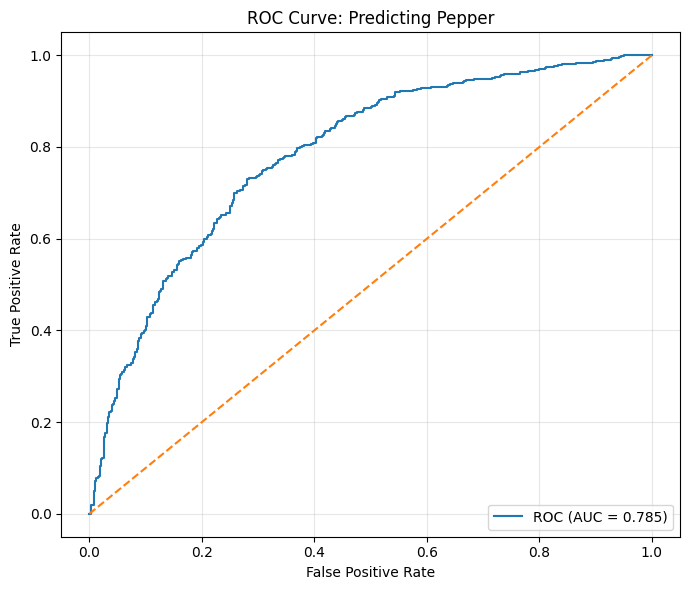

In [ ]:
# Let's build a classification model that predicts whether a professor receives a “pepper” from all available factors.

# Combine our predictors of interest (num and tags), removing one gender as before for perfect collinearity concern
X = df_clean[['average_difficulty', 'num_ratings', 'would_take_again', 'num_online_ratings', 'male'] + tag_cols]
y = df_clean['pepper']

# Data split using 80-20
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=N_number
)

# Get variables same scale and create the pipeline for training, implementing class weights for balance + using logistic regression
pipe = Pipeline([
    ('scaler', MinMaxScaler()),
    ('logreg', LogisticRegression(
        penalty='l2',
        max_iter=1000,
        class_weight='balanced',
        solver='liblinear',
        random_state=N_number
    ))
])

# Fit once to find the best threhold to use
pipe.fit(X_train, y_train)
train_prob = pipe.predict_proba(X_train)[:, 1]
fpr_tr, tpr_tr, thresholds_tr = roc_curve(y_train, train_prob)
optimal_threshold = thresholds_tr[np.argmax(tpr_tr - fpr_tr)]
print(f"Suggested threshold (from train): {optimal_threshold:.3f}")

# Let's check over multiple C values to see what is the best regularization strength
C_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
cv_results = []

print("Cross-Validation Results (5-Fold)")
print("C\tAUROC\tF1\tRecall")

for C in C_values:
    pipe.set_params(logreg__C=C)

    scores = cross_validate(
        pipe,
        X_train,
        y_train,
        cv=5,
        scoring=['roc_auc', 'f1', 'recall'],
        n_jobs=-1
    )

    cv_results.append({
        'C': C,
        'roc_auc': scores['test_roc_auc'].mean(),
        'f1': scores['test_f1'].mean(),
        'recall': scores['test_recall'].mean()
    })

    print(f"{C}\t{scores['test_roc_auc'].mean():.3f}"
          f"\t{scores['test_f1'].mean():.3f}"
          f"\t{scores['test_recall'].mean():.3f}")

# Use the C value corresponding to the best AUROC value
cv_df = pd.DataFrame(cv_results)
optimal_C = cv_df.loc[cv_df['roc_auc'].idxmax(), 'C']
print(f"\nOptimal C based on AUROC: {optimal_C}")

# Retrain best model using optimal C value
pipe.set_params(logreg__C=optimal_C)
pipe.fit(X_train, y_train)

# Test evaluation
y_prob = pipe.predict_proba(X_test)[:, 1]
y_pred = (y_prob > optimal_threshold).astype(int)

print("Final Model Performance:")
print(classification_report(y_test, y_pred))

fpr, tpr, _ = roc_curve(y_test, y_prob)
test_auc = auc(fpr, tpr)

print(f"Test AUROC: {test_auc:.3f}")

plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, label=f"ROC (AUC = {test_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle='--')  # chance line

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: Predicting Pepper")
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Welch's t-test for Number of Ratings by Gender: t = 3.326, p = 0.0008882066


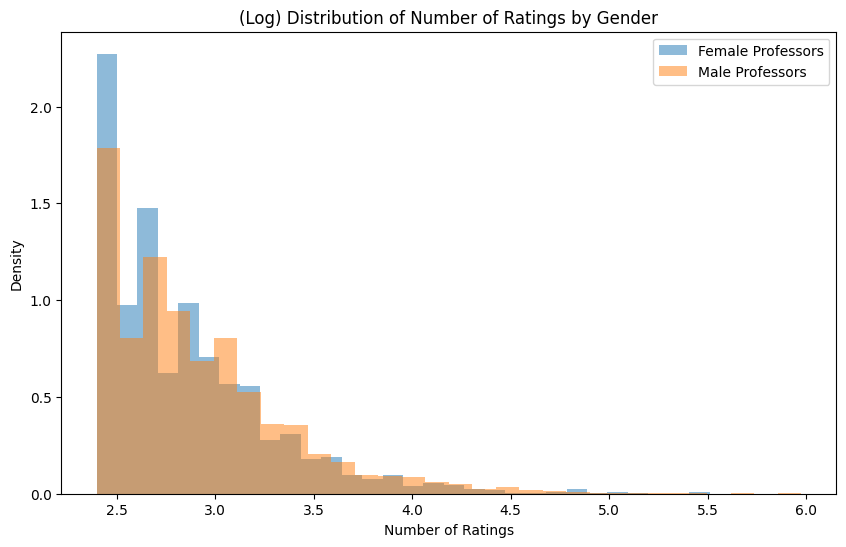

In [ ]:
# Is there a difference in the number of ratings received by gender?

# Get the number of ratings for male and female professors
female_num_ratings = df_clean[df_clean['female'] == 1]['num_ratings']
male_num_ratings = df_clean[df_clean['male'] == 1]['num_ratings']

# Do a Welch's t-test on number of ratings by gender
t_stat_gender_num_ratings, p_val_gender_num_ratings = ttest_ind(male_num_ratings, female_num_ratings, equal_var=False, alternative='two-sided')

print(f'\nWelch\'s t-test for Number of Ratings by Gender: t = {t_stat_gender_num_ratings:.3f}, p = {p_val_gender_num_ratings:.10f}')

plt.figure(figsize=(10, 6))
plt.hist(np.log(female_num_ratings), bins=30, alpha=0.5, label='Female Professors', density=True)
plt.hist(np.log(male_num_ratings), bins=30, alpha=0.5, label='Male Professors', density=True)
plt.xlabel('Number of Ratings')
plt.ylabel('Density')
plt.title('(Log) Distribution of Number of Ratings by Gender')
plt.legend()
plt.show()